# Décomposition d'un champ de vent en fonction de courant et potentiel de vitesse

Auteur : FERRY Frédéric (DESR/ENM/C3M) - novembre 2021

On utilise ici les données quotidiennes NCEP de vent zonal et vent méridien pour l'année 2016. Pour récupérer les données d'autres années aller à l'adresse suivante : ftp://ftp2.psl.noaa.gov/Datasets/ncep.reanalysis.dailyavgs/pressure/

Concepts illustrés :

- Calcul de divergence horizontale et de tourbillon relatif pour des champs globaux (windspharm)
- Décomposition fonction de courant et potentiel de vitesse pour des champs globaux (windspharm)
- Tracé de cartes (cartopy)

<div class="alert alert-warning">
<b>Attention : </b> Nécessite le pckage windspharm uniquement disponible sur Mac/Linux
</div>

<div class="alert alert-warning">
    
$$\Delta(\Psi) =\xi$$
$$\Delta(\chi) =div(\vec{V}_h)$$

Obtention du potentiel de vitesse et de la fonction de courant par inversion du laplacien :  
$$u, v -> \xi, div(\vec{V}_h) -> \Psi, \chi$$
</div>

In [33]:
import os
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.util import add_cyclic_point

from mpl_toolkits.axes_grid1 import AxesGrid

from windspharm.standard import VectorWind
from windspharm.tools import prep_data, recover_data, order_latdim
from windspharm.examples import example_data_path

In [34]:
year='2016'
month='01'
day='15'
date=year+'-'+month+'-'+day
plev=200

In [35]:
#--  Read u, v data for specified vertical level

fu    = xr.open_dataset('./data/uwnd.'+year+'.nc').sel(level=plev).sel(time=date)
fv    = xr.open_dataset('./data/vwnd.'+year+'.nc').sel(level=plev).sel(time=date)

time  = fu.time.values
lat = fu.lat.values

#--  Extract variables
u = fu['uwnd']
v = fv['vwnd']

In [36]:
def lonflip(da):
    lon_name = 'lon'
    da['_longitude_adjusted'] = xr.where(
        da[lon_name] > 180,
        da[lon_name] - 360,
        da[lon_name])
    da = (
        da
        .swap_dims({lon_name: '_longitude_adjusted'})
        .sel(**{'_longitude_adjusted': sorted(da._longitude_adjusted)})
        .drop(lon_name))
    da = da.rename({'_longitude_adjusted': lon_name})
    return da

u0 = lonflip(u)
v0 = lonflip(v)

In [37]:
lon0 = u0.coords['lon']
lon_idx = u0.dims.index('lon')
u1, lon = add_cyclic_point(u0.values, coord=lon0, axis=lon_idx)
v1, lon = add_cyclic_point(v0.values, coord=lon0, axis=lon_idx)
print("Original shape -", u0.shape)
print("New shape -", u1.shape)

Original shape - (73, 144)
New shape - (73, 145)


In [38]:
wind_mod = (u1*u1+v1*v1)**0.5

In [39]:
def plot_background(ax):
   ax.coastlines()
   ax.set_xticks(np.linspace(-180, 180, 10), crs=projection)
   ax.set_yticks(np.linspace(-90, 90, 10), crs=projection)
   lon_formatter = LongitudeFormatter(zero_direction_label=True)
   lat_formatter = LatitudeFormatter()
   ax.xaxis.set_major_formatter(lon_formatter)
   ax.yaxis.set_major_formatter(lat_formatter)
   return ax

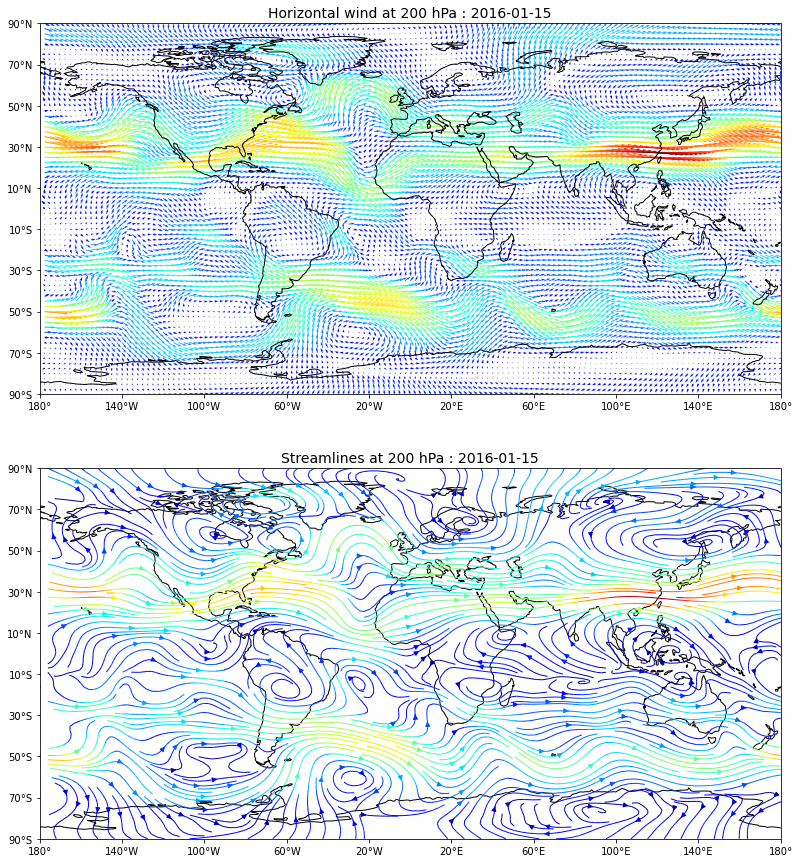

In [43]:
projection = ccrs.PlateCarree()

fig = plt.figure(figsize=(15., 15.))
ax = fig.add_subplot(211, projection=projection)
ax.set_title('Horizontal wind at '+str(plev)+' hPa : '+ date, loc='center', fontsize=14)
plot_background(ax)
wind = ax.quiver(lon, lat, u1, v1, wind_mod, cmap='jet', scale=2000,
                 width=0.001, angles='xy', transform=ccrs.PlateCarree())

ax = fig.add_subplot(212, projection=projection)
ax.set_title('Streamlines at '+str(plev)+' hPa : '+ date, loc='center', fontsize=14)
plot_background(ax)
ax.set_global()
wind2= ax.streamplot(lon, lat, np.array(u1), np.array(v1), transform=ccrs.PlateCarree(),
                  linewidth=1, density=3, color=np.array(wind_mod), cmap='jet')

figname='./figs/NCEP_sfvp_wind_'+date
plt.savefig(figname+'.png',bbox_inches='tight')

plt.show()

In [44]:
uwnd, uwnd_info = prep_data(u1, 'yx')
vwnd, vwnd_info = prep_data(v1, 'yx')

lats, uwnd, vwnd = order_latdim(lat, uwnd, vwnd)

w = VectorWind(uwnd, vwnd)

sf, vp = w.sfvp()
vor = w.vorticity()
div = w.divergence()
uchi, vchi = w.irrotationalcomponent()
upsi, vpsi = w.nondivergentcomponent()

sf = recover_data(sf, uwnd_info)
vp = recover_data(vp, uwnd_info)
vor = recover_data(vor, uwnd_info)
div = recover_data(div, uwnd_info)

uchi = recover_data(uchi, uwnd_info)
upsi = recover_data(upsi, uwnd_info)
vchi = recover_data(vchi, uwnd_info)
vpsi = recover_data(vpsi, uwnd_info)

chi_wind_mod = (uchi*uchi+vchi*vchi)**0.5
psi_wind_mod = (upsi*upsi+vpsi*vpsi)**0.5

In [45]:
levels_div = np.arange(-20,21,1)
levels_vor = np.arange(-15,16,1)
levels_vp = np.arange(-20,21,1)
levels_sf = np.arange(-150,160,10)

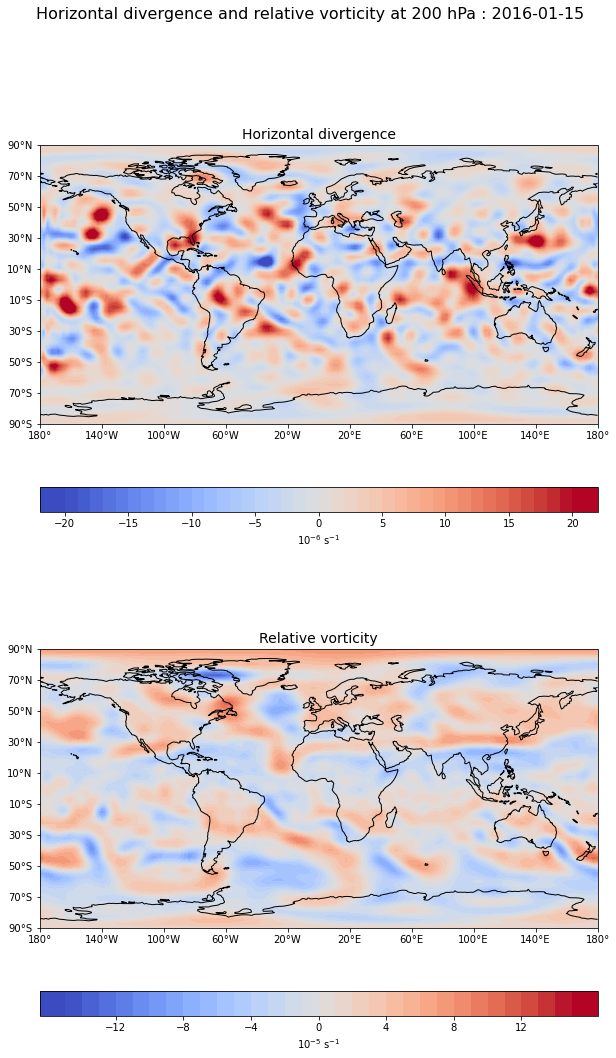

In [46]:
fig = plt.figure(figsize=(10., 17.))
fig.suptitle('Horizontal divergence and relative vorticity at '+str(plev)+' hPa : '+ date, fontsize=16)

ax = fig.add_subplot(2, 1, 1, projection=projection)
ax.set_title('Horizontal divergence', loc='center', fontsize=14)
plot_background(ax)
cf = ax.contourf(lon, lat, div * 1e06, levels_div, transform=ccrs.PlateCarree(), cmap='coolwarm', extend='both')
cb = fig.colorbar(cf, orientation='horizontal', extendrect=True)
cb.set_label('10$^{-6}$ s$^{-1}$')

ax = fig.add_subplot(2, 1, 2, projection=projection)
ax.set_title('Relative vorticity', loc='center', fontsize=14)
plot_background(ax)
cf = ax.contourf(lon, lat, vor * 1e05, levels_vor, transform=ccrs.PlateCarree(), cmap='coolwarm', extend='both')
cb = fig.colorbar(cf, orientation='horizontal', extendrect=True)
cb.set_label('10$^{-5}$ s$^{-1}$')

figname='./figs/NCEP_sfvp_div_vort_'+date
plt.savefig(figname+'.png',bbox_inches='tight')

plt.show()

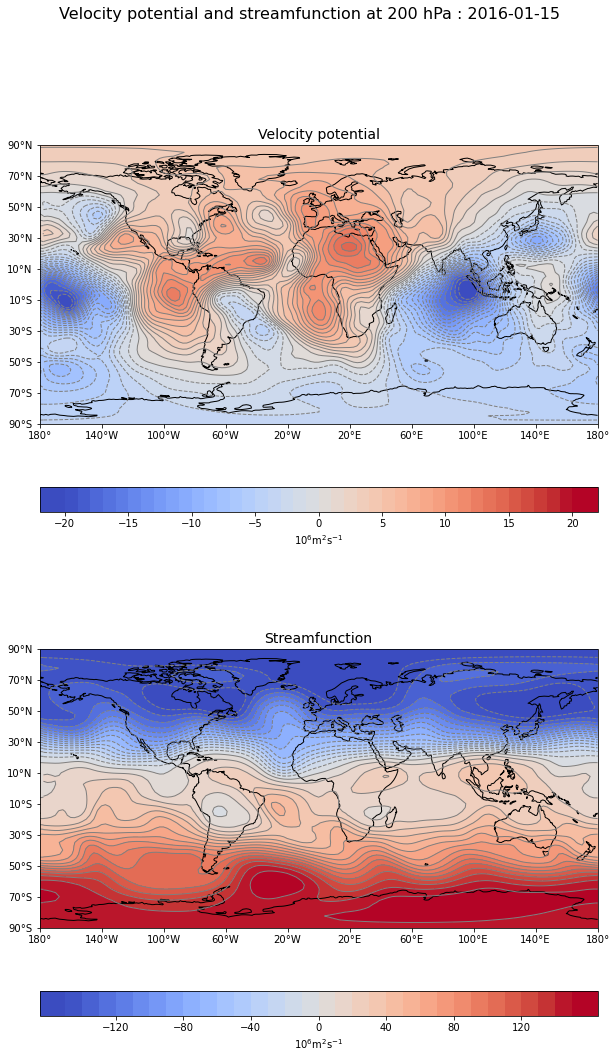

In [47]:
fig = plt.figure(figsize=(10., 17.))
fig.suptitle('Velocity potential and streamfunction at '+str(plev)+' hPa : '+ date, fontsize=16)

ax = fig.add_subplot(2, 1, 1, projection=projection)
ax.set_title('Velocity potential', loc='center', fontsize=14)
plot_background(ax)
cf = ax.contourf(lon, lat, vp * 1e-06, levels_vp, transform=ccrs.PlateCarree(), cmap='coolwarm', extend='both')
c = ax.contour(lon, lat, vp * 1e-06, levels_vp, colors='grey', linewidths=1, transform=ccrs.PlateCarree())
cb = fig.colorbar(cf, orientation='horizontal', extendrect=True)
cb.set_label('$10^6$m$^2$s$^{-1}$')

ax = fig.add_subplot(2, 1, 2, projection=projection)
ax.set_title('Streamfunction', loc='center', fontsize=14)
plot_background(ax)
c = ax.contour(lon, lat, sf * 1e-06, levels_sf, colors='grey', linewidths=1, transform=ccrs.PlateCarree())
cf = ax.contourf(lon, lat, sf * 1e-06, levels_sf, transform=ccrs.PlateCarree(), cmap='coolwarm', extend='both')
cb = fig.colorbar(cf, orientation='horizontal', extendrect=True)
cb.set_label('$10^6$m$^2$s$^{-1}$')

figname='./figs/NCEP_sfvp1_'+date
plt.savefig(figname+'.png',bbox_inches='tight')

plt.show()

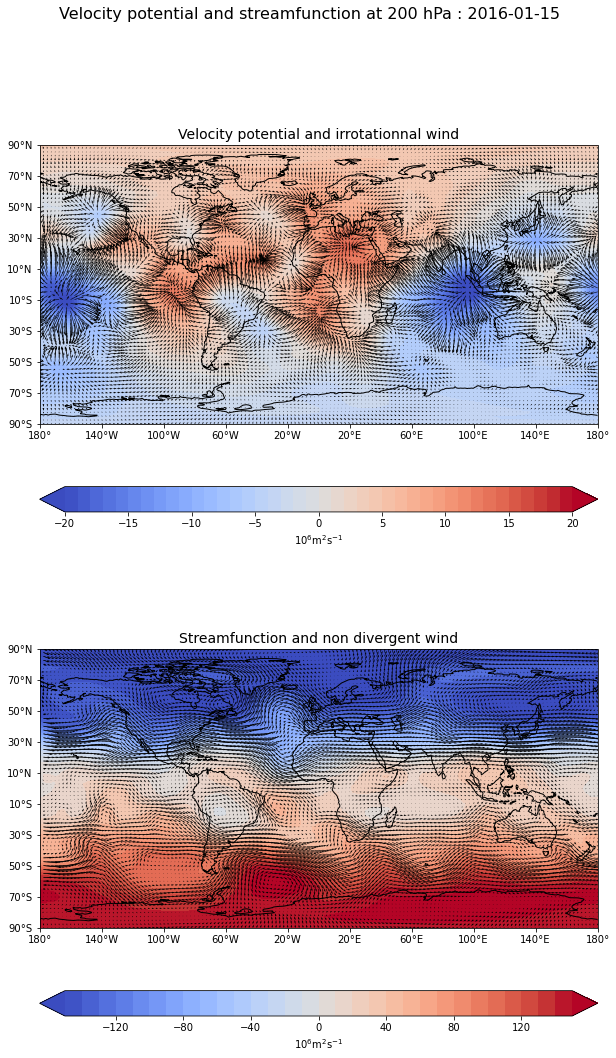

In [48]:
fig = plt.figure(figsize=(10., 17.))
fig.suptitle('Velocity potential and streamfunction at '+str(plev)+' hPa : '+ date, fontsize=16)

ax = fig.add_subplot(2, 1, 1, projection=projection)
ax.set_title('Velocity potential and irrotationnal wind', loc='center', fontsize=14)
plot_background(ax)

cf = ax.contourf(lon, lat, vp * 1e-06, levels_vp, transform=ccrs.PlateCarree(), cmap='coolwarm', extend='both')
cb = fig.colorbar(cf, orientation='horizontal')
cb.set_label('$10^6$m$^2$s$^{-1}$')
wind = ax.quiver(lon, lat, uchi, vchi, scale=300, width=0.001, angles='xy', color='black', transform=ccrs.PlateCarree())

ax = fig.add_subplot(2, 1, 2, projection=projection)
ax.set_title('Streamfunction and non divergent wind', loc='center', fontsize=14)
plot_background(ax)

cf = ax.contourf(lon, lat, sf * 1e-06, levels_sf, transform=ccrs.PlateCarree(), cmap='coolwarm', extend='both')
cb = fig.colorbar(cf, orientation='horizontal')
cb.set_label('$10^6$m$^2$s$^{-1}$')
wind = ax.quiver(lon, lat, upsi, vpsi, scale=2000, width=0.001, angles='xy', color='black', transform=ccrs.PlateCarree())

figname='./figs/NCEP_sfvp2_'+date
plt.savefig(figname+'.png',bbox_inches='tight')

plt.show()

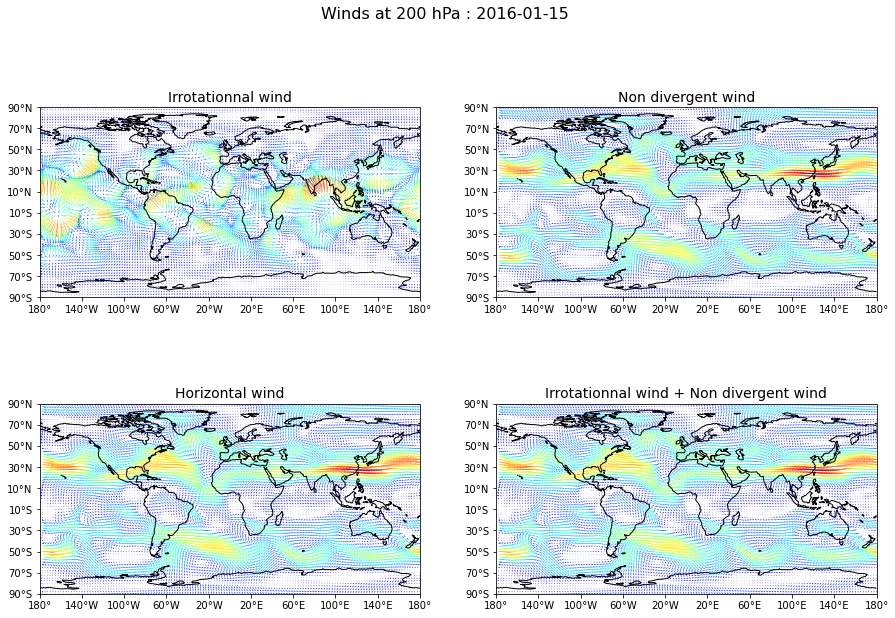

In [49]:
fig = plt.figure(figsize=(15., 10.))
fig.suptitle('Winds at '+str(plev)+' hPa : '+ date, fontsize=16)

ax = fig.add_subplot(2, 2, 1, projection=projection)
ax.set_title('Irrotationnal wind', loc='center', fontsize=14)
plot_background(ax)
wind = ax.quiver(lon, lat, uchi, vchi, chi_wind_mod, cmap='jet', scale=300, width=0.001, angles='xy', transform=ccrs.PlateCarree())

ax = fig.add_subplot(2, 2, 2, projection=projection)
ax.set_title('Non divergent wind', loc='center', fontsize=14)
plot_background(ax)
wind = ax.quiver(lon, lat, upsi, vpsi, psi_wind_mod, cmap='jet', scale=2000, width=0.001, angles='xy', transform=ccrs.PlateCarree())

ax = fig.add_subplot(2, 2, 3, projection=projection)
ax.set_title('Horizontal wind', loc='center', fontsize=14)
plot_background(ax)
wind = ax.quiver(lon, lat, u1, v1, wind_mod, cmap='jet', scale=2000, width=0.001, angles='xy', transform=ccrs.PlateCarree())

ax = fig.add_subplot(2, 2, 4, projection=projection)
ax.set_title('Irrotationnal wind + Non divergent wind', loc='center', fontsize=14)
plot_background(ax)
wind = ax.quiver(lon, lat, uchi+upsi, vchi+vpsi, wind_mod, cmap='jet', scale=2000, width=0.001, angles='xy', transform=ccrs.PlateCarree())

figname='./figs/NCEP_sfvp3_'+date
plt.savefig(figname+'.png',bbox_inches='tight')

plt.show()